# More examples of model fitting (and how to do it poorly)

### Goals:

1. To understand how spectral data is used to estimate the Doppler shift (and speed) of distant galaxies.
2. To be amazed that galaxies can be moving so quickly.
3. To try fitting spectral data from the Sloan Digital Sky Survey (SDSS).
4. To understand some of the pitfalls in fitting data.

### Timing

1. Try to finish this notebook in 30-35 minutes. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import datetime

# Sloan Digital Sky Survey

The Sloan Digital Sky Survey ([Project page](https://www.sdss.org/), [Wikipedia](https://en.wikipedia.org/wiki/Sloan_Digital_Sky_Survey)) truly changed the way we understand the universe.  

Over the course of 20 years, SDSS observed 35% of the sky and catalogued about 1 billion stars and galaxies.

In addition to taking images of such a large part of the sky, SDSS also measures the spectrum of the light from over 4 million objects.  

The spectra are obtained by feeding an individual optical fiber for each target through a hole drilled in an aluminum plate.  The light from the fiber is then passed into a diffraction grating to separate out the different wavelengths. The diffracted light was then directed to an array of sensors, so that each sensor measured the amount of light at a different wavelength.

Each hole is positioned specifically for a selected target, so every field in which spectra are to be acquired requires a unique plate. In spectroscopic mode, the telescope tracks the sky in the standard way, keeping the objects focused on their corresponding fiber tips. 

Here is a picture of one such aluminum plate:

<div>
<img src="figures/plate-sdss.jpg" width="400"/>
</div>

We are going to be looking at the data from one fiber for one plate.  

We can measure the distance of objects by taking advantage of the Doppler shift and what we know about atomic emission lines. Atomic transitions result in the emission of known wavelengths of light. Because the targets are moving with respect to earth, these wavelengths will be shifted. We can measure this Doppler shift of the light from a given target object.

In [2]:
data = np.loadtxt(open("../data/sds_galaxy.txt", 'rb'), usecols=range(3))

# This is how we pull out the data from columns in the array.

# They put the data in angstroms, let's use nanometers instead. 1 angstrom = 0.1 nm
wavelength = data[:,0]*0.1
sfd = data[:,1]
best_fit = data[:,2]

`sfd` above refers to the "spectral flux density", which is the amount of electromagnetic energy received by the detector per unit area, per unit time, per unit wavelength. The units are $\frac{{\rm erg}}{{\rm cm}^{2}s^{1}{{\rm angstrom}}^{1}}$ (which we'll omit in the plots below for the sake of brevity).

You can think of this as the power from a narrow wavelength band that would be seen by a 1 cm$^2$ detector.

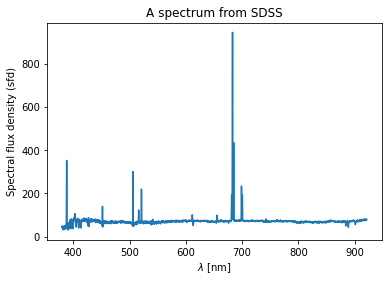

In [4]:
plt.plot(wavelength, best_fit)
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Spectral flux density (sfd)")
plt.title("A spectrum from SDSS")
plt.show()

### $H\alpha$ line

The brightest line in this spectrum is the [hydrogen $\alpha$ line](https://en.wikipedia.org/wiki/H-alpha), which is emitted when an electron de-excites from the $n=3$ to $n=2$ energy level of the hydrogen atom. In vacuum in the rest frame of the hydrogen atom, the H-alpha line has a wavelength of 656.46 nm.

Let's use this dataset to make a quick estimate of the wavelength of the H $\alpha$ line, the redshift of the object, and its velocity.

In [6]:
# calculate which item in the array has the largest value
peak_idx = np.argmax(sfd)
# pick out the corresponding wavelength
peak_wl = wavelength[peak_idx]
print(f"The peak wavelength in data is {peak_wl:0.2f} nm")

H_alpha = 656.4614
print(f"In the rest frame of the H atom, the H alpha line is at {H_alpha:.4f} nm")

The peak wavelength in data is 682.97 nm
In the rest frame of the H atom, the H alpha line is at 656.4614 nm


Let's define a function to calculate the redshift of the object, defined as 
$$z = \frac{\lambda_\mathrm{observed}}{\lambda_\mathrm{emitted}} - 1,$$

and the velocity divided by the speed of light $c$, or $\beta=\frac{v}{c}$ value:

$$\beta = \frac{1-\lambda_\mathrm{emitted}^2/\lambda_\mathrm{observed}^2}{1+\lambda_\mathrm{emitted}^2/\lambda_\mathrm{observed}^2}$$


In [7]:
def redshift(l_sdss,l_0):
    return (l_sdss/l_0)-1

def beta(l_sdss,l_0):
    r2 = pow(l_sdss/l_0,2)
    return (1 - (1/r2))/(1 + (1/r2))

In [8]:
z1 = redshift(peak_wl,H_alpha)
print(f"This corresponds to a redshift of {z1:.5f}")
b = beta(peak_wl,H_alpha)
print(f"Based on this line we estimate that this object is moving away from us with a velocity of {b:0.4f} c")

This corresponds to a redshift of 0.04038
Based on this line we estimate that this object is moving away from us with a velocity of 0.0396 c


### Question for discussion

#### 4.1 About how far away is this object?  You can estimate it based on Hubble's law, $v = H_0 d$. Please show your work.

For the value of the Hubble parameter you can use $H_0 = 70 \, \frac{{\rm km}\,}{{\rm s}} \cdot {\rm Mpc}^{-1}$.

The speed of light is about $c = 3 \times 10^8$ m/s.

1 parsec (pc) = 3.26 light years (ly).

Note that this computation leaves out some subtleties, like what we mean by "how far away", as in "how far away when the light was emitted?" or "how far away right now?", and that isn't even getting into the issues that come up when we consider relativity or the acceleration of the Universe. But at least it gives you a distance scale to think about.

If you are curious about the details, have a look at this: [Ned Wright's Cosmological Distance Calculator](http://www.astro.ucla.edu/~wright/CosmoCalc.html)

### Zoom in on $H \alpha$ line

If we zoom in on the line, we see it is actually three lines.   That complicates things for trying to fit the lines to a model, as we would have to include all three lines in our model.  

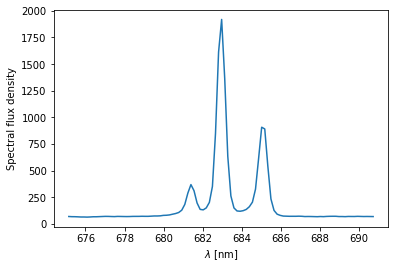

In [9]:
cutout_wl = wavelength[peak_idx-50:peak_idx+50]
cutout_sfd = sfd[peak_idx-50:peak_idx+50]
plt.plot(cutout_wl, cutout_sfd)
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Spectral flux density")
plt.show()

Instead, let's focus on fitting a simpler case.

### The $H \beta$ line.

The brightest line near 500 nm is the $H \beta$ line, the little sibling of the $H \alpha$ line, which arises from the $n=4$ to $n=2$ transition. It is more isolated, making it a better choice for us to fit with a simple model.

In [10]:
mask = (wavelength > 500) & (wavelength < 510)
cutout_wl = wavelength[mask]
cutout_sfd = sfd[mask]

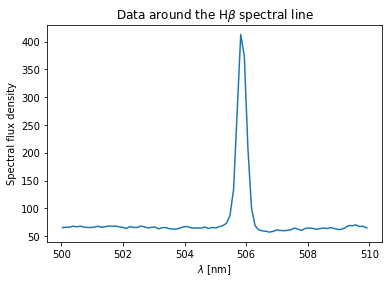

In [11]:
plt.plot(cutout_wl, cutout_sfd)
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Spectral flux density")
plt.title(r"Data around the H$\beta$ spectral line")
plt.show()

# Our model

Now we want to characterize this line. We would like to know the peak location, peak intensity, and width of the peak. Notice that the H$\beta$ line is also on top of what looks like a flat background flux rate. How do we extract this information?

We are going to fit this line to a model with two parts.

   1. We will model this line itself as a unit Gaussian $ G(\lambda | \mu, \sigma)$ times a prefactor that gives the height of the peak ($n$).  
   2. We will model the background as a slope and offset.  To reduce the correlation between the two, we will define the offset at 500 nm. $p_0 + (\lambda - 500) \cdot p_1$.
   
This gives us a model with five parameters: $(n, \mu, \sigma, p_0, p_1)$.

$m(\lambda \, | \, n, \mu, \sigma, p_0, p_1) = n \, G(\lambda | \mu, \sigma) + p_0 + (\lambda - 500) \cdot p_1$.

The next cell codes up the model and the functions we need for the fitting. This is just a slightly more complicated version of what we did in the first notebook, because this model has a few more parameters.

In [12]:
def Gauss(x, n, mu, sigma):
    return n*stats.norm(loc=mu, scale=sigma).pdf(x)

def poly1(x, offset, slope):
    return offset + (x-500)*slope

def model_func(x, prefact, mu, sigma, offset, slope):
    return Gauss(x, prefact, mu, sigma) + poly1(x, offset, slope)

def generic_chi2(params, data_vals, model, x):
    model_vals = model(x, *params)
    return np.sum((data_vals - model_vals)**2)

### Initial guess

Let's guess some initial values for the parameters and plot the model to see how it looks.

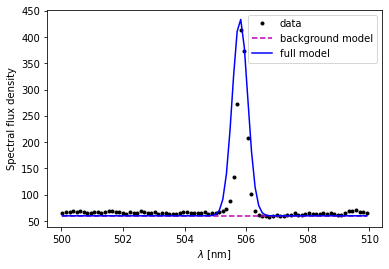

In [13]:
n_0 = 235.
mu_0 = 505.8
sigma_0 = 0.25
offset_0 = 60.
slope_0 = 0.

init_pars = (n_0, mu_0, sigma_0, offset_0, slope_0)
model_vals = model_func(cutout_wl, *init_pars)
background_vals = poly1(cutout_wl, init_pars[3], init_pars[4])

plt.plot(cutout_wl, cutout_sfd, 'k.', label="data")
plt.plot(cutout_wl, background_vals, 'm--', label="background model")
plt.plot(cutout_wl, model_vals, 'b', label="full model")
plt.xlabel(r'$\lambda$ [nm]')
plt.ylabel(r'Spectral flux density')
plt.legend()
plt.show()

# Getting the cost function

First we are going to fit using a cost function that uses the full model to compare to the data.  

Similar to what we did in the first notebook, we need to write a wrapper function that uses our specific data and takes only the model parameters as inputs.

In [14]:
def our_cost_func(params):
    return generic_chi2(params, cutout_sfd, model_func, cutout_wl)

print(f"Initial chi squared: {our_cost_func(init_pars):.2f}")

Initial chi squared: 95492.91


### Fitting the model

Let's go ahead and fit the model and print out the results.

In [15]:
result = optimize.minimize(our_cost_func, x0=np.array(init_pars))
fit_pars = result['x']
model_fit = model_func(cutout_wl, *fit_pars)
background_fit = poly1(cutout_wl, fit_pars[3], fit_pars[4])
print("Best Fit ---------")
print(f"Line Intensity: {fit_pars[0]:.1f} [spectral flux density units]")
print(f"Line Peak Location: {fit_pars[1]:.4f} [nm]")
print(f"Line Width: {fit_pars[2]:.4f} [nm]")
print(f"Background at 500 nm: {fit_pars[3]:.2f} [sfd units]")
print(f"Background slope: {fit_pars[4]:.2f} [sfd units / nm]")

Best Fit ---------
Line Intensity: 132.0 [spectral flux density units]
Line Peak Location: 505.8599 [nm]
Line Width: 0.1474 [nm]
Background at 500 nm: 66.80 [sfd units]
Background slope: -0.31 [sfd units / nm]


### Plotting the fit results

Let's make a plot of the data and the model, and let's break out the background part of the model.

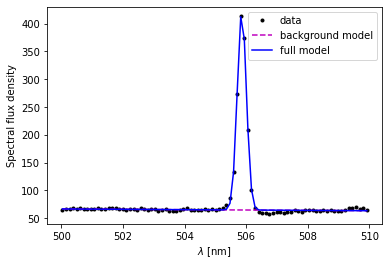

In [16]:
plt.plot(cutout_wl, cutout_sfd, 'k.', label="data")
plt.plot(cutout_wl, background_fit, 'm--', label="background model")
plt.plot(cutout_wl, model_fit, 'b', label="full model")
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Spectral flux density")
plt.legend()
plt.show()

### Questions for discussion

#### 5.1 Before going further, it is important to make sure you understand the previous plot. Write a description of the plot, how we made it, and what each part means. How did we get from the previous plot, with the initial guess for the model parameters, to this one?

In [17]:
H_beta = 486.2721

z2 = (fit_pars[1]/H_beta)-1
print(f"We fit the peak of the line at {fit_pars[1]:.4f} nm")
print(f"In a vacuum, the H beta line is at {H_beta:.4f} nm")

z1 = redshift(fit_pars[1],H_beta)
print(f"This corresponds to a redshift of {z1:.5f}")
b = beta(fit_pars[1],H_beta)
print(f"Based on this line we estimate that this object is moving away from us with a velocity of {b:0.4f} c")

We fit the peak of the line at 505.8599 nm
In a vacuum, the H beta line is at 486.2721 nm
This corresponds to a redshift of 0.04028
Based on this line we estimate that this object is moving away from us with a velocity of 0.0395 c


### How to do a bad fit, version 1, using a bad model

Let's see what happens if we forget to include background model. To do that we are going to construct a cost function using just the Gaussian instead of the full model.

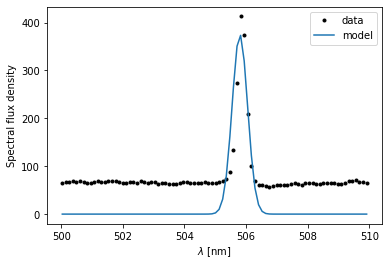

In [18]:
def bad_cost_func(params):
    return generic_chi2(params, cutout_sfd, Gauss, cutout_wl)

init_pars_bad = (n_0, mu_0, sigma_0)
model_fit_bad = Gauss(cutout_wl, *init_pars_bad)
plt.plot(cutout_wl, cutout_sfd, 'k.', label="data")
plt.plot(cutout_wl, model_fit_bad, label="model")
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Spectral flux density")
plt.legend()
plt.show()

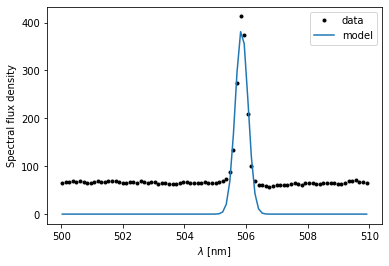

Best Fit ---------
Line Intensity: 199.5 [sfd units]
Line Peak Location: 505.8582 [nm]
Line Width: 0.2062 [nm]


In [19]:
result_bad = optimize.minimize(bad_cost_func, x0=np.array(init_pars_bad))
fit_pars_bad_1 = result_bad['x']
model_fit_bad = Gauss(cutout_wl, *fit_pars_bad_1)
plt.plot(cutout_wl, cutout_sfd, 'k.', label="data")
plt.plot(cutout_wl, model_fit_bad, label="model")
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Spectral flux density")
plt.legend()
plt.show()

print("Best Fit ---------")
print(f"Line Intensity: {fit_pars_bad_1[0]:.1f} [sfd units]")
print(f"Line Peak Location: {fit_pars_bad_1[1]:.4f} [nm]")
print(f"Line Width: {fit_pars_bad_1[2]:.4f} [nm]")

### Questions for discussion

#### 6.1 What's the difference between this fit and the previous fit? How would you interpret this result?  Do the parameters make sense?

### How to do a bad fit, version 2, using bad initial parameters

Now we are going to use the full model again, but we will see what happens if we choose bad parameters for our initial guess.


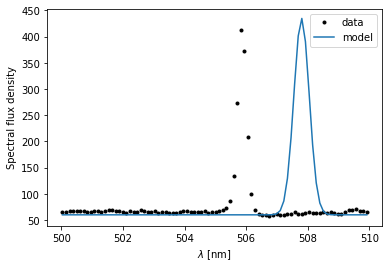

In [20]:
# Use the same initial params, except offset the gaussian mean by 2 nm
init_pars_bad_2 = (n_0, mu_0+2.0, sigma_0, offset_0, slope_0)
model_fit_bad = model_func(cutout_wl, *init_pars_bad_2)

plt.plot(cutout_wl, cutout_sfd, 'k.', label='data')
plt.plot(cutout_wl, model_fit_bad, label='model')
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Spectral flux density")
plt.legend()
plt.show()

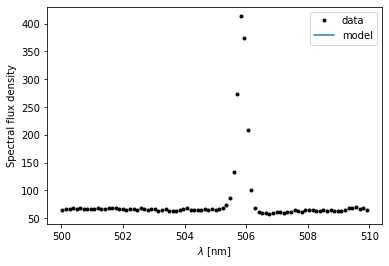

Best Fit ---------
Line Intensity: 153562.7 [sfd units]
Line Peak Location: 1203.4477 [nm]
Line Width: -3875.0356 [nm]
Background at 500 nm: 171041.61 [sfd units]
Background slope: -38671.61 [sfd units / nm]


In [21]:
result_bad_2 = optimize.minimize(our_cost_func, x0=np.array(init_pars_bad_2))
fit_pars_bad_2 = result_bad_2['x']
model_fit_bad_2 = model_func(cutout_wl, *fit_pars_bad_2)

plt.plot(cutout_wl, cutout_sfd, 'k.', label="data")
plt.plot(model_fit_bad_2, label="model")
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Spectral flux density")
plt.legend()
plt.show()

print("Best Fit ---------")
print(f"Line Intensity: {fit_pars_bad_2[0]:.1f} [sfd units]")
print(f"Line Peak Location: {fit_pars_bad_2[1]:.4f} [nm]")
print(f"Line Width: {fit_pars_bad_2[2]:.4f} [nm]")
print(f"Background at 500 nm: {fit_pars_bad_2[3]:.2f} [sfd units]")
print(f"Background slope: {fit_pars_bad_2[4]:.2f} [sfd units / nm]")

### Questions for discussion

#### 7.1 How would you interpret the fit result?  Do the parameters make sense?

#### 7.2 This illustrates that it is often important to start with a reasonable initial guess. If we were fitting millions of spectra, we would want the program to make the initial guess instead of having to do it by hand.  How might you systematically make an initial guess for the a) line peak, b) the line width, c) the background at 500 nm, d) the background slope?
